In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\tmc500.csv")

df.head()

,abort,abortedtakeoff,above,abuse,abusive,accomplish,acquire,acrid,across,activerunway,...,class13,class14,class15,class16,class17,class18,class19,class20,class21,class22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

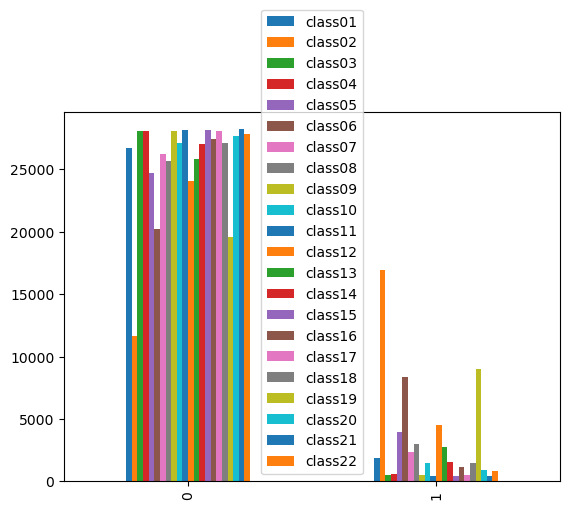

In [2]:
df1 = df[df.columns[500:]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

In [15]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [4]:
import numpy as np

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [5]:
X = np.asarray(df[df.columns[0:500]])
y = np.asarray(df[df.columns[500:]])

X_sub, y_sub = get_minority_samples(X, y)
X_res, y_res = MLSMOTE(X_sub, y_sub, 5720, 5)  # Applying MLSMOTE to augment the dataframe

<AxesSubplot:>

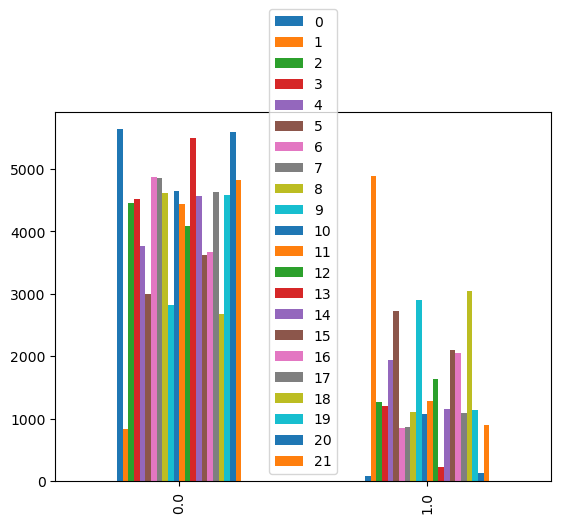

In [6]:
df2 = y_res.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")



In [7]:
irlbl = y_res.sum(axis=0)
print(irlbl)

0       83.0
1     4892.0
2     1273.0
3     1198.0
4     1947.0
5     2720.0
6      846.0
7      873.0
8     1109.0
9     2894.0
10    1076.0
11    1285.0
12    1635.0
13     228.0
14    1152.0
15    2095.0
16    2050.0
17    1095.0
18    3042.0
19    1135.0
20     130.0
21     898.0
dtype: float64


In [8]:
df_res = pd.concat([X_res, y_res], axis=1)

In [9]:
df_res.to_csv(r'C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\resampled_tmc500.csv')

In [26]:
X_res.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,1.949461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.949461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.model_selection import train_test_split

X = np.asarray(X_res)
y = np.asarray(y_res)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:
from skmultilearn.adapt import MLkNN

mlknn_classifier = MLkNN(k=3)
mlknn_classifier.fit(X_train , y_train)
predictions = mlknn_classifier.predict(X_test)

C:\Users\KIIT\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: Inexact indices into sparse matrices are not allowed

In [27]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

classifier = BinaryRelevance(
    classifier = SVC(),
    require_dense = [False, True]
)
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [28]:
import sklearn.metrics as metrics
metrics.hamming_loss(y_test, predictions)


0.08979656706929434

In [29]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_test, predictions)

0.3135198135198135

In [30]:
metrics.average_precision_score(y_test, predictions.todense())

0.6427092802549883

In [32]:
metrics.recall_score(y_test, predictions,average='macro')

0.6318030496646524

In [34]:
metrics.f1_score(y_test, predictions, average='macro')

0.7189980421845458